<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [X] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [X] Begin with baselines for classification.
- [X] Use scikit-learn for logistic regression.
- [X] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [X] Get your model's test accuracy. (One time, at the end.)
- [X] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [X] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [X] Do one-hot encoding.
- [X] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [X] Get and plot your coefficients.
- [X] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

# Exploration

In [7]:
df

Burrito       Date  Yelp  Google  ... Avocado  Corn  Zucchini  Great
0    California  1/18/2016   3.5     4.2  ...     NaN   NaN       NaN  False
1    California  1/24/2016   3.5     3.3  ...     NaN   NaN       NaN  False
2      Carnitas  1/24/2016   NaN     NaN  ...     NaN   NaN       NaN  False
3         Asada  1/24/2016   NaN     NaN  ...     NaN   NaN       NaN  False
4    California  1/27/2016   4.0     3.8  ...     NaN   NaN       NaN   True
..          ...        ...   ...     ...  ...     ...   ...       ...    ...
418       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN  False
419       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True
420  California  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN  False
421       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True
422       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True

[421 rows x 59 columns]

In [8]:
df.describe().T.sort_values(by='count')

count        mean  ...         75%         max
Queso             0.0         NaN  ...         NaN         NaN
Density (g/mL)   22.0    0.675277  ...    0.721726    0.865672
Mass (g)         22.0  546.181818  ...  595.000000  925.000000
Yelp             87.0    3.887356  ...    4.000000    4.500000
Google           87.0    4.167816  ...    4.400000    5.000000
Circum          281.0   22.135765  ...   23.000000   29.000000
Volume          281.0    0.786477  ...    0.880000    1.540000
Length          283.0   20.038233  ...   21.500000   26.000000
Salsa           396.0    3.371970  ...    4.000000    5.000000
Temp            401.0    3.783042  ...    4.500000    5.000000
Meat            407.0    3.620393  ...    4.000000    5.000000
Meat:filling    412.0    3.586481  ...    4.000000    5.000000
Cost            414.0    7.067343  ...    7.880000   25.000000
Wrap            418.0    3.979904  ...    5.000000    5.000000
Fillings        418.0    3.539833  ...    4.000000    5.000000
Hunger          418.0    3.495335  ...    4.000000    5.000000
Uniformity      419.0    3.428998  ...    4.000000    5.000000
Synergy         419.0    3.586993  ...    4.000000    5.000000
Tortilla        421.0    3.519477  ...    4.000000    5.000000

[19 rows x 8 columns]

In [0]:
# drop 'Queso' feature as it has no data
df = df.drop(columns='Queso')

In [10]:
df.describe(exclude='number').T.sort_values(by='unique')

count unique         top freq
Chile relleno     4      1           x    4
Ham               2      1           x    2
Zucchini          1      1           x    1
Nopales           4      1           x    4
Lobster           1      1           x    1
Egg               5      1           x    5
Carrots           1      1           x    1
Bacon             3      1           x    3
Sushi             2      1           x    2
Unreliable       33      1           x   33
Avocado          13      1           x   13
Mushroom          3      1           x    3
Corn              3      2           x    2
Pineapple         7      2           x    5
Taquito           4      2           x    3
Onion            17      2           x    9
Cilantro         15      2           x    9
Salsa.1           7      2           x    6
Sauce            38      2           x   33
Cabbage           8      2           x    6
Bell peper        7      2           x    4
Great           421      2       False  239
Lettuce          11      2           x    9
NonSD             7      2           x    5
Beef            179      2           x  137
Pico            158      2           x  127
Guac            154      2           x  114
Cheese          159      2           x  128
Tomato            7      2           x    5
Fries           127      2           x  102
Pork             51      2           x   36
Chicken          21      2           x   20
Shrimp           21      2           x   17
Fish              6      2           x    4
Rice             36      2           x   26
Beans            35      2           x   27
Sour cream       92      2           x   67
Chips            26      4           x   21
Burrito         421      5  California  169
Date            421    169   8/30/2016   29

In [11]:
for column in df.select_dtypes(exclude='number').columns:
  if df[column].nunique() < 50:
    print(column, df[column].unique())

Burrito ['California' 'Carnitas' 'Asada' 'Other' 'Surf & Turf']
Chips [nan 'x' 'X' 'Yes' 'No']
Unreliable [nan 'x']
NonSD [nan 'x' 'X']
Beef ['x' nan 'X']
Pico ['x' nan 'X']
Guac ['x' nan 'X']
Cheese ['x' nan 'X']
Fries ['x' nan 'X']
Sour cream [nan 'x' 'X']
Pork [nan 'x' 'X']
Chicken [nan 'x' 'X']
Shrimp [nan 'x' 'X']
Fish [nan 'x' 'X']
Rice [nan 'x' 'X']
Beans [nan 'x' 'X']
Lettuce [nan 'x' 'X']
Tomato [nan 'x' 'X']
Bell peper [nan 'x' 'X']
Carrots [nan 'x']
Cabbage [nan 'x' 'X']
Sauce [nan 'x' 'X']
Salsa.1 [nan 'x' 'X']
Cilantro [nan 'x' 'X']
Onion [nan 'x' 'X']
Taquito [nan 'x' 'X']
Pineapple [nan 'x' 'X']
Ham [nan 'x']
Chile relleno [nan 'x']
Nopales [nan 'x']
Lobster [nan 'x']
Egg [nan 'x']
Mushroom [nan 'x']
Bacon [nan 'x']
Sushi [nan 'x']
Avocado [nan 'x']
Corn [nan 'x' 'X']
Zucchini [nan 'x']
Great [False  True]


In [12]:
# most of the categorical features seem like simple yes/no indicators
# convert them to 1 for yes, 0 for no (assuming nans = no)

yes_no_features = df.select_dtypes(exclude='number').columns.drop(['Burrito', 'Great', 'Date'])
yes_no_features

Index(['Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese',
       'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice',
       'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage',
       'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
       'Chile relleno', 'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon',
       'Sushi', 'Avocado', 'Corn', 'Zucchini'],
      dtype='object')

In [13]:
for column in yes_no_features:
  df[column] = df[column].str.replace('x|X|Yes', '1').str.replace('No', '0').fillna(0).astype(int)

df[yes_no_features]

Chips  Unreliable  NonSD  Beef  ...  Sushi  Avocado  Corn  Zucchini
0        0           0      0     1  ...      0        0     0         0
1        0           0      0     1  ...      0        0     0         0
2        0           0      0     0  ...      0        0     0         0
3        0           0      0     1  ...      0        0     0         0
4        1           0      0     1  ...      0        0     0         0
..     ...         ...    ...   ...  ...    ...      ...   ...       ...
418      0           0      0     0  ...      0        0     0         0
419      0           0      0     0  ...      0        0     0         0
420      0           0      0     0  ...      0        0     0         0
421      0           0      0     0  ...      0        0     0         0
422      0           0      0     0  ...      0        0     0         0

[421 rows x 37 columns]

In [14]:
# all the yes_no_features except 'Chips', 'Unreliable', and 'NonSD' are ingredients
# engineer a 'total_ingredients' feature and a 'no_ingredients' feature

ingredients_features = yes_no_features.drop(['Chips', 'Unreliable', 'NonSD'])
ingredients_features

Index(['Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork',
       'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato',
       'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro',
       'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno', 'Nopales',
       'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn',
       'Zucchini'],
      dtype='object')

In [0]:
df['total_ingredients'] = df[ingredients_features].sum(axis=1)
df['no_ingredients'] = df[ingredients_features].sum(axis=1) == 0

In [16]:
# day of week, day of month, and month might be good predictors,
# since i am doing train/val/test split on years, i will add features for those
# then remove the date column after splitting

df['day_of_month'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce').dt.day
df['day_of_week'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce').dt.dayofweek
df['month'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce').dt.month

df[['day_of_month', 'day_of_week', 'month']].isnull().sum()

day_of_month    0
day_of_week     0
month           0
dtype: int64

In [0]:
pd.options.display.max_rows = 1000

In [18]:
df.dtypes

Burrito               object
Date                  object
Yelp                 float64
Google               float64
Chips                  int64
Cost                 float64
Hunger               float64
Mass (g)             float64
Density (g/mL)       float64
Length               float64
Circum               float64
Volume               float64
Tortilla             float64
Temp                 float64
Meat                 float64
Fillings             float64
Meat:filling         float64
Uniformity           float64
Salsa                float64
Synergy              float64
Wrap                 float64
Unreliable             int64
NonSD                  int64
Beef                   int64
Pico                   int64
Guac                   int64
Cheese                 int64
Fries                  int64
Sour cream             int64
Pork                   int64
Chicken                int64
Shrimp                 int64
Fish                   int64
Rice                   int64
Beans         

In [19]:
df.isnull().sum()

Burrito                0
Date                   0
Yelp                 334
Google               334
Chips                  0
Cost                   7
Hunger                 3
Mass (g)             399
Density (g/mL)       399
Length               138
Circum               140
Volume               140
Tortilla               0
Temp                  20
Meat                  14
Fillings               3
Meat:filling           9
Uniformity             2
Salsa                 25
Synergy                2
Wrap                   3
Unreliable             0
NonSD                  0
Beef                   0
Pico                   0
Guac                   0
Cheese                 0
Fries                  0
Sour cream             0
Pork                   0
Chicken                0
Shrimp                 0
Fish                   0
Rice                   0
Beans                  0
Lettuce                0
Tomato                 0
Bell peper             0
Carrots                0
Cabbage                0


In [0]:
%%capture
!pip install -U pandas-profiling
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [43]:
df.profile_report().to_notebook_iframe()

# Assignment

## Do train/validate/test split.

 Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [22]:
date = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')
print(f'nulls: {date.isnull().sum()}')
print(f'min: {date.min()}')
print(f'max: {date.max()}')

nulls: 0
min: 2011-05-16 00:00:00
max: 2026-04-25 00:00:00


In [23]:
date[date.dt.year>2019]
# probably a typo, change to 2016

77   2026-04-25
Name: Date, dtype: datetime64[ns]

In [24]:
df['Date'].dtype

dtype('O')

In [25]:
df['Date'] = df['Date'].str.replace('2026', '2016')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')
df['Date'].describe()

count                     421
unique                    169
top       2016-08-30 00:00:00
freq                       29
first     2011-05-16 00:00:00
last      2019-08-27 00:00:00
Name: Date, dtype: object

In [26]:
df_train = df[df['Date'].dt.year <= 2016].drop(columns='Date')
df_val = df[df['Date'].dt.year == 2017].drop(columns='Date')
df_test = df[df['Date'].dt.year >= 2018].drop(columns='Date')

df_train.shape, df_val.shape, df_test.shape

((299, 62), (85, 62), (37, 62))

## Begin with baselines for classification.

In [27]:
target = 'Great'

y_train = df_train[target]

majority_class = y_train.mode()[0]

print(f'majority class: {majority_class}')

y_train.value_counts(normalize=True)

majority class: False


False    0.588629
True     0.411371
Name: Great, dtype: float64

In [28]:
from sklearn.metrics import accuracy_score

y_pred = [majority_class] * len(y_train)
accuracy_baseline_train = accuracy_score(y_train, y_pred)

print(f'baseline majority class train accuracy: {accuracy_baseline_train * 100:.2f}%')

y_val = df_val[target]
y_pred = [majority_class] * len(y_val)
accuracy_baseline_val = accuracy_score(y_val, y_pred)

print(f'baseline majority class validation accuracy: {accuracy_baseline_val * 100:.2f}%')

baseline majority class train accuracy: 58.86%
baseline majority class validation accuracy: 55.29%


## Use scikit-learn for logistic regression.

In [29]:
df_train.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64'), dtype('bool')],
      dtype=object)

In [30]:
target = 'Great'

features = df_train.columns.drop(target)
features

Index(['Burrito', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger', 'Mass (g)',
       'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp',
       'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy',
       'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese',
       'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice',
       'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage',
       'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
       'Chile relleno', 'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon',
       'Sushi', 'Avocado', 'Corn', 'Zucchini', 'total_ingredients',
       'no_ingredients', 'day_of_month', 'day_of_week', 'month'],
      dtype='object')

In [0]:
X_train = df_train[features]
X_val = df_val[features]

y_train = df_train[target]
y_val = df_val[target]

In [32]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer(strategy='mean', add_indicator=True)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model1 = LogisticRegressionCV(n_jobs=-1, random_state=42)
model1.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=42, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

## Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [33]:
accuracy_val1 = model1.score(X_val_scaled, y_val)
print(f'validation accuracy, model 1: {accuracy_val1 * 100:.2f}%')

validation accuracy, model 1: 83.53%


In [34]:
model2 = LogisticRegressionCV(n_jobs=-1, random_state=42, cv=10)
model2.fit(X_train_scaled, y_train)

accuracy_val2 = model2.score(X_val_scaled, y_val)
print(f'validation accuracy, model 1: {accuracy_val2 * 100:.2f}%')

validation accuracy, model 1: 83.53%


In [35]:
model3 = LogisticRegressionCV(n_jobs=-1, random_state=42, cv=10, Cs=100)
model3.fit(X_train_scaled, y_train)

accuracy_val3 = model3.score(X_val_scaled, y_val)
print(f'validation accuracy, model 1: {accuracy_val3 * 100:.2f}%')

validation accuracy, model 1: 80.00%


In [36]:
model4 = LogisticRegressionCV(n_jobs=-1, random_state=42, cv=10, Cs=1)
model4.fit(X_train_scaled, y_train)

accuracy_val4 = model4.score(X_val_scaled, y_val)
print(f'validation accuracy, model 1: {accuracy_val4 * 100:.2f}%')

validation accuracy, model 1: 55.29%


In [37]:
model5 = LogisticRegressionCV(n_jobs=-1, random_state=42, cv=7)
model5.fit(X_train_scaled, y_train)

accuracy_val5 = model5.score(X_val_scaled, y_val)
print(f'validation accuracy, model 1: {accuracy_val5 * 100:.2f}%')

validation accuracy, model 1: 83.53%


## Get your model's test accuracy. (One time, at the end.)

In [38]:
# tested different parameters for models, chose one,
# now recombine train and val to process and fit
# before running on the test data

df_retrain = df_train.append(df_val)

df_retrain.shape, df_train.shape, df_val.shape

((384, 62), (299, 62), (85, 62))

In [39]:
85 + 299

384

In [0]:
X_retrain = df_retrain[features]
X_test = df_test[features]

y_retrain = df_retrain[target]
y_test = df_test[target]

In [41]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegressionCV(n_jobs=-1)
)

pipeline.fit(X_retrain, y_retrain)
accuracy_test = pipeline.score(X_test, y_test)

print(f'Test accuracy: {accuracy_test * 100:.2f}%')

Test accuracy: 75.68%


# Stretch goals

## Add your own stretch goal(s) !

- added features
- use logregcv
 - tried different parameters

## Get and plot your coefficients.

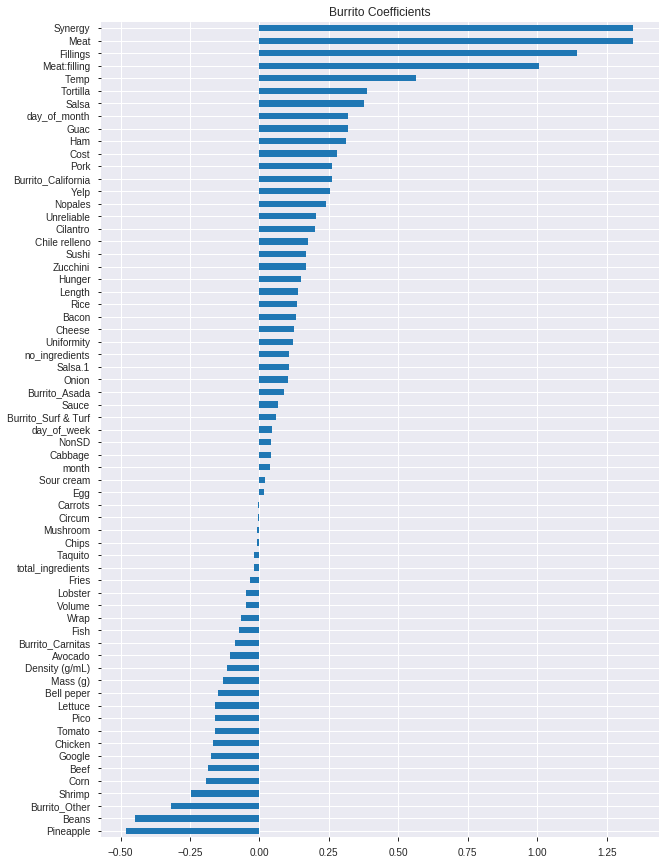

In [42]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

model = pipeline.named_steps['logisticregressioncv']

coefficients = model.coef_[0]

encoder = pipeline.named_steps['onehotencoder']

feature_names = encoder.feature_names

coefficients = pd.Series(coefficients, feature_names)


coefficients.sort_values().plot.barh(figsize=(10,15))
plt.title('Burrito Coefficients')
plt.show()